In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt

In [3]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [7]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [8]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

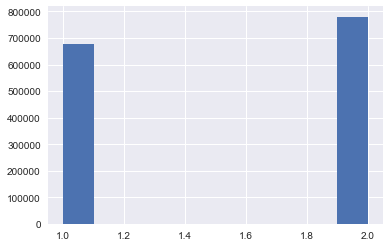

In [9]:
train['vendor_id'].hist()

In [10]:
train['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

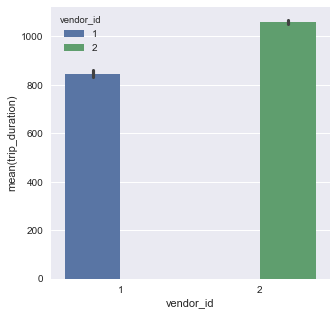

In [11]:
# vendorid having 2 seems to have a larger duration
fig,axes = plt.subplots(figsize = (5,5))
sns.barplot(data=train, x='vendor_id',y='trip_duration',hue='vendor_id')

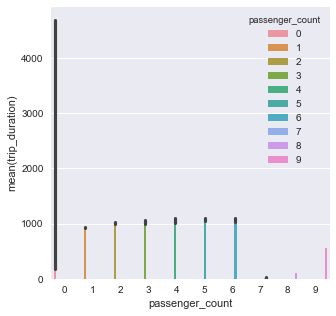

In [12]:
# Number of people fom 1 to 6 almost have same time to travel as opposed to 7 to 9.
fig,axes = plt.subplots(figsize = (5,5))
sns.barplot(data=train, x='passenger_count',y='trip_duration',hue='passenger_count')

NYC Border limits are such that 
city_long_border = (-74.03, -73.75) city_lat_border = (40.63, 40.85)
With that being defined, the rest of the other points we could sufficiently assume other datapoints are outliers.

In [13]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [14]:
train.shape

(1439183, 11)

In [15]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
print("Mean: {:.3f}  Standard Dev:{:.3f}".format(m,s))
Train = train[train['trip_duration'] <= m + 2*s]
Train = train[train['trip_duration'] >= m - 2*s]

Mean: 946.231  Standard Dev:5251.641


In [16]:
Train.shape

(1439183, 11)

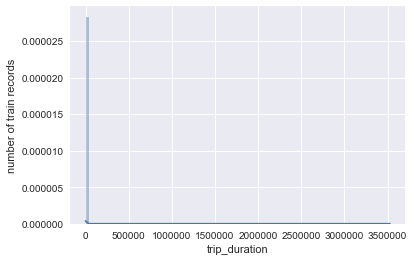

In [17]:
sns.distplot(a=train['trip_duration'],bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

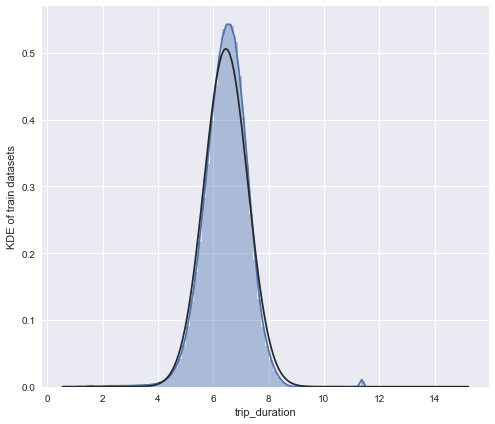

In [18]:
fig,axes = plt.subplots(figsize=(8,7))
plt.ylabel('KDE of train datasets')
plt.xlabel('log of Trip Duration')
sns.distplot(a=np.log1p(Train['trip_duration']),bins=100, fit=stats.norm)

In [19]:
Train['log_trip_duration'] = np.log1p(Train['trip_duration'])

In [20]:
Test = test

In [21]:
Train['pickup_datetime_converted'] =pd.to_datetime(Train['pickup_datetime']) 
Test['pickup_datetime_converted'] =pd.to_datetime(Test['pickup_datetime']) 

In [22]:
Train.loc[:, 'pickup_date'] = Train['pickup_datetime_converted'].dt.date
Test.loc[:, 'pickup_date'] = Test['pickup_datetime_converted'].dt.date

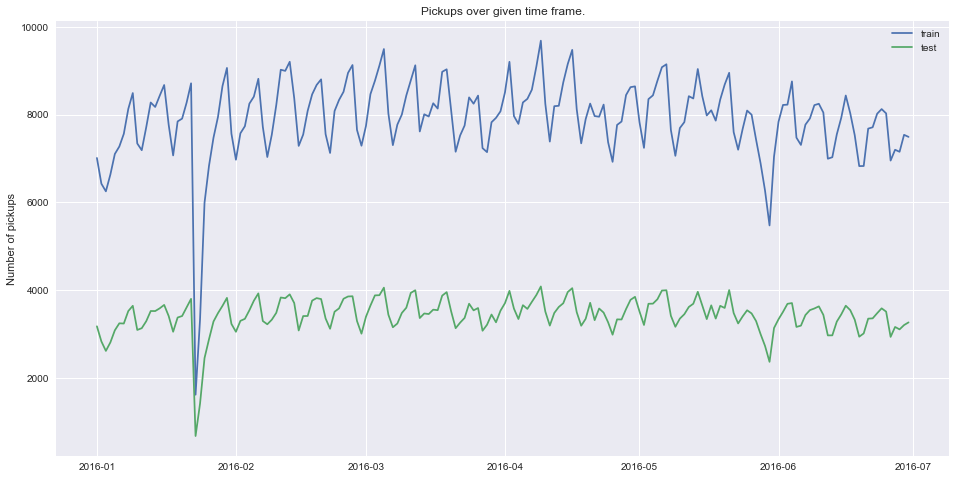

In [23]:
fig,axes = plt.subplots(figsize =(16,8))
plt.plot(Train.groupby('pickup_date').count()[['id']], 'x-', label='train')
plt.plot(Test.groupby('pickup_date').count()[['id']], 'x-', label='test')
plt.title('Pickups over given time frame.')
plt.legend(loc=0)
plt.ylabel('Number of pickups')

In [24]:
Train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_datetime_converted,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,6.122,2016-03-14 17:24:55,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,6.498,2016-06-12 00:43:35,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,7.662,2016-01-19 11:35:24,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,6.064,2016-04-06 19:32:31,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,6.078,2016-03-26 13:30:55,2016-03-26


In [25]:
Train.groupby('vendor_id')['trip_duration'].mean()

vendor_id
1    833.503
2   1044.231
Name: trip_duration, dtype: float64

In [26]:
Train.groupby('store_and_fwd_flag')['trip_duration'].mean()

store_and_fwd_flag
N    945.569
Y   1066.472
Name: trip_duration, dtype: float64

In [27]:
Train.groupby('passenger_count')['trip_duration'].mean()

passenger_count
0   1880.925
1    917.370
2    990.569
3   1013.873
4   1037.515
5   1058.289
6   1050.980
Name: trip_duration, dtype: float64

In [28]:
Train.groupby('passenger_count').size()

passenger_count
0         53
1    1019950
2     207167
3      59104
4      28011
5      77127
6      47771
dtype: int64

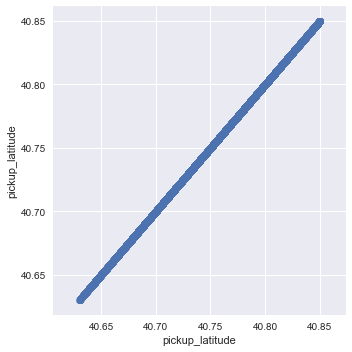

In [29]:
sns.lmplot(x='pickup_latitude',y = 'pickup_latitude',fit_reg=False,data=Train)

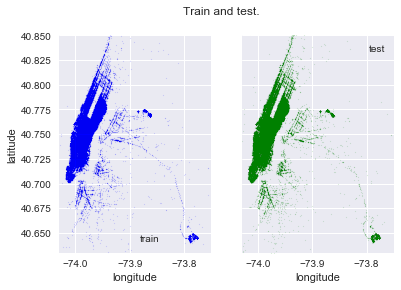

In [30]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(Train['pickup_longitude'].values[:N], Train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(Test['pickup_longitude'].values[:N], Test['pickup_latitude'].values[:N],
              color='green', s=1,label='test', alpha=0.1)
fig.suptitle('Train and test.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [31]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [32]:
Train.loc[:, 'distance_haversine'] = haversine_array(Train['pickup_latitude'].values, Train['pickup_longitude'].values, Train['dropoff_latitude'].values, Train['dropoff_longitude'].values)
Test.loc[:, 'distance_haversine'] = haversine_array(Test['pickup_latitude'].values, Test['pickup_longitude'].values, Test['dropoff_latitude'].values, Test['dropoff_longitude'].values)    
    
Train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(Train['pickup_latitude'].values, Train['pickup_longitude'].values, Train['dropoff_latitude'].values, Train['dropoff_longitude'].values)
Test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(Test['pickup_latitude'].values, Test['pickup_longitude'].values, Test['dropoff_latitude'].values, Test['dropoff_longitude'].values)

Train.loc[:, 'direction'] = bearing_array(Train['pickup_latitude'].values, Train['pickup_longitude'].values, Train['dropoff_latitude'].values, Train['dropoff_longitude'].values)
Test.loc[:, 'direction'] = bearing_array(Test['pickup_latitude'].values, Test['pickup_longitude'].values, Test['dropoff_latitude'].values, Test['dropoff_longitude'].values)

In [33]:
Train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_datetime_converted,pickup_date,distance_haversine,distance_dummy_manhattan,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,6.122,2016-03-14 17:24:55,2016-03-14,1.499,1.735,99.970
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,6.498,2016-06-12 00:43:35,2016-06-12,1.806,2.431,-117.154
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,7.662,2016-01-19 11:35:24,2016-01-19,6.385,8.204,-159.680
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,6.064,2016-04-06 19:32:31,2016-04-06,1.485,1.661,-172.738
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,6.078,2016-03-26 13:30:55,2016-03-26,1.189,1.199,179.474
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.983,40.742,-73.992,40.749,N,443,6.096,2016-01-30 22:01:40,2016-01-30,1.099,1.554,-44.996
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969,40.758,-73.957,40.766,N,341,5.835,2016-06-17 22:34:59,2016-06-17,1.326,1.874,47.506
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969,40.798,-73.922,40.761,N,1551,7.347,2016-05-21 07:54:58,2016-05-21,5.715,8.079,136.385
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999,40.738,-73.986,40.733,N,255,5.545,2016-05-27 23:12:23,2016-05-27,1.310,1.775,118.284
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981,40.744,-73.973,40.790,N,1225,7.112,2016-03-10 21:45:01,2016-03-10,5.121,5.754,7.604


In [34]:
Test

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetime_converted,pickup_date,distance_haversine,distance_dummy_manhattan,direction
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N,2016-06-30 23:59:58,2016-06-30,2.746,2.913,-3.595
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N,2016-06-30 23:59:53,2016-06-30,2.759,3.105,172.279
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N,2016-06-30 23:59:47,2016-06-30,1.306,1.846,133.326
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N,2016-06-30 23:59:41,2016-06-30,5.269,7.163,-150.957
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N,2016-06-30 23:59:33,2016-06-30,0.961,1.354,130.260
5,id0668992,1,2016-06-30 23:59:30,1,-73.991,40.750,-73.981,40.787,N,2016-06-30 23:59:30,2016-06-30,4.186,4.995,12.530
6,id1765014,1,2016-06-30 23:59:15,1,-73.978,40.742,-73.952,40.717,N,2016-06-30 23:59:15,2016-06-30,3.513,4.940,140.985
7,id0898117,1,2016-06-30 23:59:09,2,-74.013,40.702,-73.986,40.720,N,2016-06-30 23:59:09,2016-06-30,2.981,4.211,47.864
8,id3905224,2,2016-06-30 23:58:55,2,-73.992,40.731,-73.876,40.875,N,2016-06-30 23:58:55,2016-06-30,18.852,25.925,31.368
9,id1543102,2,2016-06-30 23:58:46,1,-73.993,40.749,-73.979,40.761,N,2016-06-30 23:58:46,2016-06-30,1.820,2.564,39.931


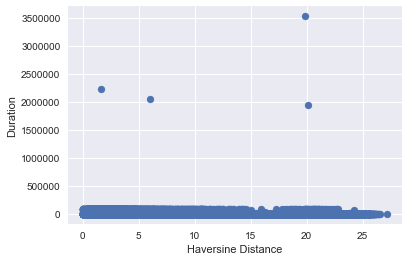

In [35]:
fig,axes = plt.subplots()
axes.scatter(x=Train['distance_haversine'].values,y=Train['trip_duration'].values)
plt.xlabel("Haversine Distance")
plt.ylabel("Duration")

In [36]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [37]:
coords

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ..., 
       [ 40.70737076, -74.00443268],
       [ 40.75710678, -73.97463226],
       [ 40.79058456, -73.97280884]])

In [38]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [39]:
Train.loc[:, 'pickup_cluster'] = kmeans.predict(Train[['pickup_latitude', 'pickup_longitude']])
Train.loc[:, 'dropoff_cluster'] = kmeans.predict(Train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [40]:
Train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_datetime_converted,pickup_date,distance_haversine,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,6.122,2016-03-14 17:24:55,2016-03-14,1.499,1.735,99.970,65,95
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,6.498,2016-06-12 00:43:35,2016-06-12,1.806,2.431,-117.154,36,49
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,7.662,2016-01-19 11:35:24,2016-01-19,6.385,8.204,-159.680,53,14
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,6.064,2016-04-06 19:32:31,2016-04-06,1.485,1.661,-172.738,28,14
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,6.078,2016-03-26 13:30:55,2016-03-26,1.189,1.199,179.474,59,75


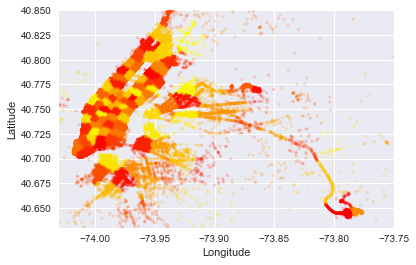

In [41]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(Train.pickup_longitude.values[:500000], Train.pickup_latitude.values[:500000], s=10, lw=0,
           c=Train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [42]:
Train['Month'] = Train['pickup_datetime_converted'].dt.month
test['Month'] = test['pickup_datetime_converted'].dt.month

In [43]:
Train.groupby('Month').count()['id'],test.groupby('Month').count()['id']

(Month
 1    226764
 2    235370
 3    252812
 4    248210
 5    244940
 6    231087
 Name: id, dtype: int64, Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 Name: id, dtype: int64)

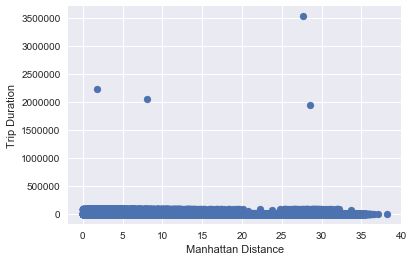

In [44]:
fig,axes = plt.subplots()
axes.scatter(x=Train['distance_dummy_manhattan'].values,y=Train['trip_duration'].values)
plt.xlabel("Manhattan Distance")
plt.ylabel("Trip Duration")

In [45]:
Train['Day'] = Train['pickup_datetime_converted'].dt.day
test['Day'] = test['pickup_datetime_converted'].dt.day

In [46]:
Train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_trip_duration,pickup_datetime_converted,pickup_date,distance_haversine,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,Month,Day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,6.122,2016-03-14 17:24:55,2016-03-14,1.499,1.735,99.970,65,95,3,14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,6.498,2016-06-12 00:43:35,2016-06-12,1.806,2.431,-117.154,36,49,6,12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,7.662,2016-01-19 11:35:24,2016-01-19,6.385,8.204,-159.680,53,14,1,19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,6.064,2016-04-06 19:32:31,2016-04-06,1.485,1.661,-172.738,28,14,4,6
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,6.078,2016-03-26 13:30:55,2016-03-26,1.189,1.199,179.474,59,75,3,26


In [47]:
Train['Hour'] = Train['pickup_datetime_converted'].dt.hour
test['Hour'] = test['pickup_datetime_converted'].dt.hour

In [48]:
Train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_datetime_converted,pickup_date,distance_haversine,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,Month,Day,Hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,2016-03-14 17:24:55,2016-03-14,1.499,1.735,99.970,65,95,3,14,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,2016-06-12 00:43:35,2016-06-12,1.806,2.431,-117.154,36,49,6,12,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,2016-01-19 11:35:24,2016-01-19,6.385,8.204,-159.680,53,14,1,19,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,2016-04-06 19:32:31,2016-04-06,1.485,1.661,-172.738,28,14,4,6,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,2016-03-26 13:30:55,2016-03-26,1.189,1.199,179.474,59,75,3,26,13


In [49]:
Train.groupby('Day').size() , test.groupby('Day').size()

(Day
 1     45898
 2     47133
 3     47305
 4     48984
 5     49530
 6     48864
 7     48074
 8     47595
 9     48996
 10    48183
 11    48252
 12    49440
 13    48693
 14    49880
 15    49178
 16    50368
 17    48248
 18    47246
 19    48620
 20    48562
 21    47581
 22    46631
 23    40907
 24    43236
 25    45807
 26    46935
 27    46314
 28    45238
 29    46199
 30    38602
 31    22684
 dtype: int64, Day
 1     20203
 2     20503
 3     20828
 4     21002
 5     21540
 6     21392
 7     20881
 8     20862
 9     21308
 10    20698
 11    21011
 12    21200
 13    21097
 14    21672
 15    21202
 16    21686
 17    21090
 18    20584
 19    21106
 20    21070
 21    20790
 22    20626
 23    17786
 24    18974
 25    19861
 26    20097
 27    20037
 28    19687
 29    19834
 30    16594
 31     9913
 dtype: int64)

In [50]:
Train['Hour'].value_counts().sort_index(ascending = True),test['Hour'].value_counts().sort_index(ascending = True)


(0     51979
 1     37594
 2     27247
 3     20261
 4     15132
 5     14535
 6     32772
 7     55066
 8     66498
 9     67170
 10    64934
 11    67909
 12    71266
 13    70797
 14    73475
 15    70996
 16    63692
 17    75758
 18    89750
 19    89405
 20    82873
 21    82779
 22    79052
 23    68243
 Name: Hour, dtype: int64, 0     22714
 1     16529
 2     11961
 3      8881
 4      6814
 5      6468
 6     14122
 7     23818
 8     28854
 9     29127
 10    27997
 11    29145
 12    30448
 13    30524
 14    32345
 15    31000
 16    27714
 17    32916
 18    38841
 19    38437
 20    36295
 21    35746
 22    34567
 23    29871
 Name: Hour, dtype: int64)

(array([ 116820.,   35393.,   47307.,  188734.,  132843.,  142063.,
         208163.,  165508.,  172278.,  230074.]),
 array([  0. ,   2.3,   4.6,   6.9,   9.2,  11.5,  13.8,  16.1,  18.4,
         20.7,  23. ]),
 <a list of 10 Patch objects>)

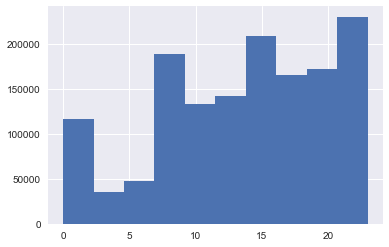

In [51]:
plt.hist(Train['Hour'])

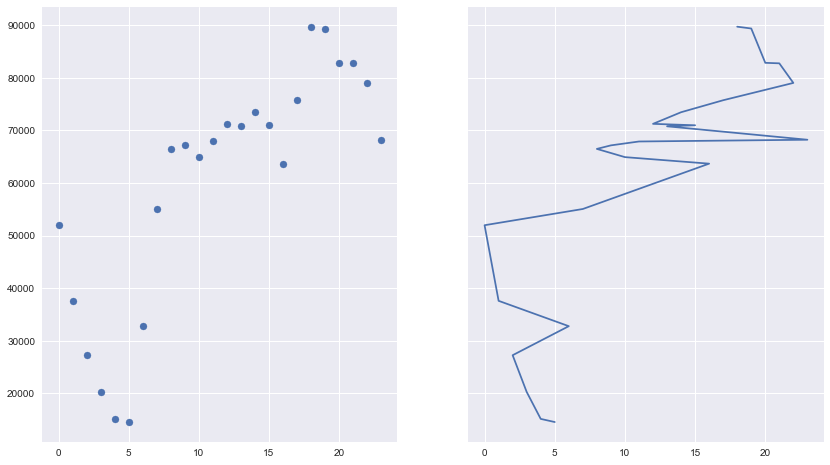

In [52]:
fig, axes = plt.subplots(ncols=2,nrows=1,sharey=True,figsize=(14,8))
axes[0].scatter(Train['Hour'].value_counts().index,Train['Hour'].value_counts().values)
axes[1].plot(Train['Hour'].value_counts().index,Train['Hour'].value_counts().values)

In [53]:
Train['h_average_speed'] = 1000 * Train['distance_haversine']/Train['trip_duration']
Train['m_avg_speed'] = 1000 * Train['distance_dummy_manhattan'] / train['trip_duration']

In [54]:
Train['m_avg_speed']

0          3.814
1          3.666
2          3.862
3          3.873
4          2.757
5          3.508
6          5.495
7          5.209
8          6.960
9          4.697
10         3.987
11         4.702
12         2.023
13         5.288
14         5.437
15         4.251
16         1.746
17         4.039
18         4.703
19         7.031
20         7.204
21         3.730
22         5.366
23         5.003
24        11.712
25         4.549
26         6.886
27         6.358
28         3.693
29         4.905
           ...  
1458614    4.682
1458615    4.560
1458616    2.419
1458617    3.946
1458618    3.821
1458619    3.836
1458620    4.964
1458621    2.618
1458622    1.756
1458623    3.486
1458624    7.026
1458625    2.579
1458626    6.397
1458627    3.376
1458628    5.404
1458629    5.569
1458630    3.312
1458631    6.718
1458632    6.741
1458633    4.146
1458634    7.134
1458635    3.638
1458636    1.223
1458637    6.535
1458638    5.667
1458639    2.141
1458640   12.303
1458641   13.9

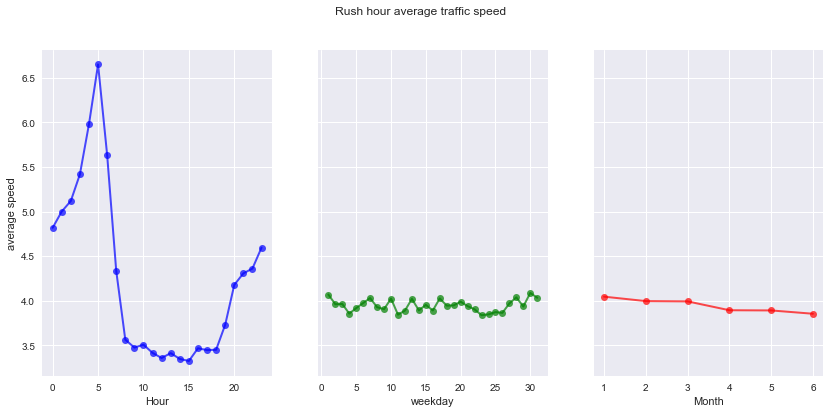

In [55]:
fig, ax = plt.subplots(ncols=3, sharey=True,figsize=(14,6))
ax[0].plot(Train.groupby('Hour').mean()['h_average_speed'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(Train.groupby('Day').mean()['h_average_speed'], 'go-', lw=2, alpha=0.7)
ax[2].plot(Train.groupby('Month').mean()['h_average_speed'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('Month')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

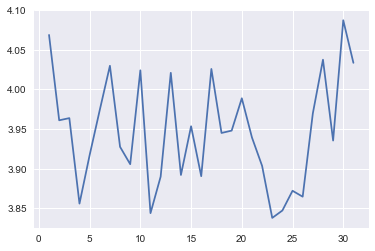

In [56]:
plt.plot(Train.groupby('Day').mean()['h_average_speed'])

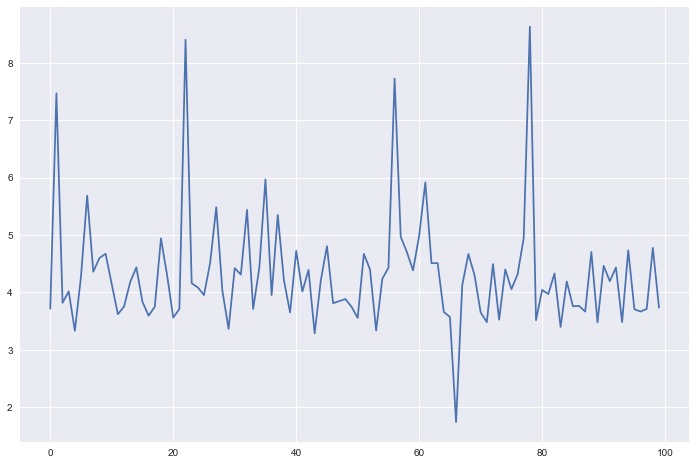

In [57]:
fig,axes = plt.subplots(figsize=(12,8))
plt.plot(Train.groupby('pickup_cluster').mean()['h_average_speed'])

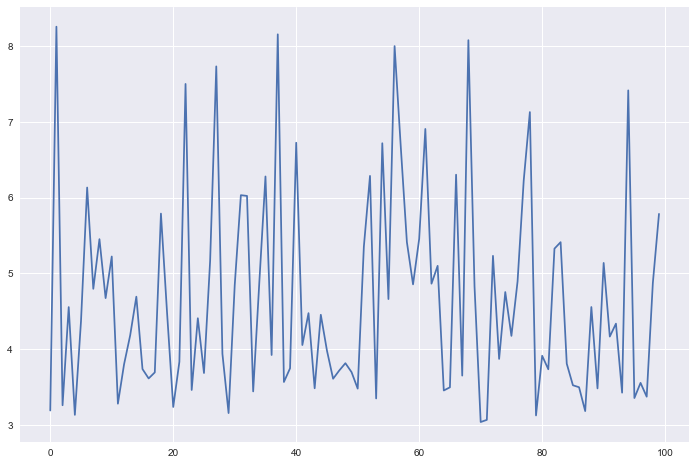

In [58]:
fig,axes = plt.subplots(figsize=(12,8))
plt.plot(Train.groupby('dropoff_cluster').mean()['h_average_speed'])

In [59]:
Train['pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
Train['pickup_long_bin'] = np.round(train['pickup_longitude'], 3)